In [78]:
import cirq
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'H2'#'LiH'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]#[('Li', (0., 0., 0.)), ('H', (0., 0., 1.45))]
num_shots = 10000
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end

#####################################

Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anti_commuting_sets

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 1551.76it/s]


{0: [(0.12062523481381837+0j) [Z0 Z2]],
 1: [(0.174412876106516+0j) [Z2 Z3]],
 2: [(0.12062523481381837+0j) [Z1 Z3]],
 3: [(0.16592785032250768+0j) [Z0 Z3]],
 4: [(-0.09706626861762624+0j) []],
 5: [(0.1686889816869329+0j) [Z0 Z1]],
 6: [(0.16592785032250768+0j) [Z1 Z2]],
 7: [(0.04530261550868928+0j) [Y0 X1 X2 Y3], (0.171412826394024+0j) [Z1]],
 8: [(-0.04530261550868928+0j) [Y0 Y1 X2 X3], (-0.2234315367466397+0j) [Z2]],
 9: [(-0.2234315367466397+0j) [Z3], (-0.04530261550868928+0j) [X0 X1 Y2 Y3]],
 10: [(0.17141282639402405+0j) [Z0], (0.04530261550868928+0j) [X0 Y1 Y2 X3]]}

The Hamiltonian is a sum of $m$ PauliWords:

$$H=\sum_{j=0}^{m-1} \alpha_{j} P_{j}$$

In this there are $l$ completely anti-commuting sets, denoted as $H_{S_{l}}$:


$$H =\sum_{l} H_{S_{l}}$$

where each anti-commuting set is defined as:

$$H_{S_{l}}=\sum_{P_{j} \in S_{l}} \alpha_{j} P_{j}$$

where:
- $\left\{P_{j}, P_{k}\right\}=0$ for $\forall P_{j} \neq P_{k} \in S_{l}$


We want **want** the sum of the squares of the cofactors to be 1:

$$H_{S_{l}}=\sum_{P_{j} \in S_{l}} \alpha_{j} P_{j}=\gamma_{l} \sum_{P_{j} \in S_{l}} \beta_{j} P_{j}$$

- aka: $\sum_{j} \beta_{j}^{2}=1$
- and $\gamma_{l}$ is the correction factor: $\alpha_{j} =  \gamma_{l} \beta_{j}$

SO overall we can turn our Hamiltonian into $l$ anti_commutings sets as:

$$H=\sum_{l} H_{S_{l}} = \sum_{l} \sum_{\substack{j=0 \\  P_{j} \in S_{l}}}^{|S_{l}|-1} \alpha_{j} P_{j}= \sum_{l} \gamma_{l} \sum_{\substack{j=0 \\  P_{j} \in S_{l}}}^{|S_{l}|-1} \beta_{j} P_{j}$$

## STEP 1:
$$H_{S_{l}}=\sum_{P_{j} \in S_{l}} \alpha_{j} P_{j}=\gamma_{l} \sum_{P_{j} \in S_{l}} \beta_{j} P_{j}$$

In [79]:
from openfermion.ops import QubitOperator

def Get_beta_j_cofactors(qubitOp_list):
    """
    Function takes in list of anti-commuting PauliWord tuples (PauliWord, constant)
    and returns the corresponding anti-commuting sets, but with new coefcators that
    obey eq (10) in ArXiv:1908.08067 (sum_j B_j^2 = 1) and an overall correction (gamma_l).

    Args:
        anti_commuting_set (list): A list of Pauliwords, where each entry is a tuple of (PauliWord, constant)

    Returns:
        dict: A dictionary of normalised_anti_commuting_set (key = 'PauliWords') and correction factor (key = 'gamma_l')

    .. code-block:: python
       :emphasize-lines: 4

       from quchem.Unitary_partitioning import *
       Anti_commuting_set = [('I0 Z1 I2 I3', (0.1371657293179602+0j)), ('Y0 Y1 X2 X3', (-0.04919764587885283+0j))]

       Get_beta_j_cofactors(Anti_commuting_set)
       >> {'PauliWords': [  ('I0 Z1 I2 I3', (0.9412848366792171+0j)),
                            ('Y0 Y1 X2 X3', (-0.33761347164735517+0j))
                          ],
          'gamma_l': (0.14572180914107857+0j)}

    """
    factor = sum([const**2 for qubitOp in qubitOp_list for PauliStrs, const in qubitOp.terms.items()])
    
    normalised_qubitOp_list=[QubitOperator(PauliStrs, const/np.sqrt(factor)) for qubitOp in qubitOp_list for PauliStrs, const in qubitOp.terms.items()]
    
    return {'PauliWords': normalised_qubitOp_list, 'gamma_l':np.sqrt(factor)}

In [6]:
Get_beta_j_cofactors(anti_commuting_sets[10])

{'PauliWords': [(0.9668047296891765+0j) [Z0],
  (0.25551636865500044+0j) [X0 Y1 Y2 X3]],
 'gamma_l': (0.17729829109248618+0j)}

we can define an operator:

$$\mathcal{X}_{s k}=i P_{s} P_{k}$$

In [7]:
def Get_X_sk(qubitOp_Ps, qubitOp_Pk):
    """

    Converts P_s, P_k tuple into the corresponding X_sk term (PauliWord, correction_factor).
    Where X_sk = i P_s P_k [note that beta cofactors omitted in definition. When multiplying the PauliWords,
    they gain different cofactors, YX = -1i Z . This effect is taken into account by this function and the overall
    effect is returned as the correction factor.

    Args:
        X_sk (tuple): A tuple of (Pauliword_s, Pauliword_k) where each is a tuple of (PauliWord, constant)

    Returns:
        tuple: i* (P_s P_k) as a (Pauliword, constant). Note that constant here is NOT cofactor from Hamiltonian
               but in fact the correction term from multiplying all the Paulis. e.g. YX = -1i Z.

    .. code-block:: python
       :emphasize-lines: 7

       from quchem.Unitary_partitioning import *
       X_sk = (
              ('Z0 I1 I2 I3', (0.8918294488900189+0j)), # P_s
              ('Y0 X1 X2 Y3', (0.3198751585326103+0j))  # P_k
            )

       convert_X_sk(X_sk)
       >> ('X0 X1 X2 Y3', (1+0j))

    """
    convert_term ={
        'II': (1,'I'),
        'IX': (1,'X'),
        'IY': (1,'Y'),
        'IZ': (1,'Z'),

        'XI': (1,'X'),
        'XX': (1,'I'),
        'XY': (1j,'Z'),
        'XZ': (-1j,'Y'),

        'YI': (1,'Y'),
        'YX': (-1j,'Z'),
        'YY': (1,'I'),
        'YZ': (1j,'X'),

        'ZI': (1,'Z'),
        'ZX': (1j,'Y'),
        'ZY': (-1j,'X'),
        'ZZ': (1,'I')
    }
    
    
    PauliStr_tuples_Ps = [tup for PauliStrs, const in qubitOp_Ps.terms.items() for tup in PauliStrs]
    qubitNo_Ps, PauliStr_Ps = zip(*PauliStr_tuples_Ps)
    qubitNo_Ps = np.array(qubitNo_Ps)
    
    

    PauliStr_tuples_Pk = [tup for PauliStrs, const in qubitOp_Pk.terms.items() for tup in PauliStrs]
    qubitNo_Pk, PauliStr_Pk = zip(*PauliStr_tuples_Pk)
    qubitNo_Pk = np.array(qubitNo_Pk)
    
    common_qubits = np.intersect1d(qubitNo_Ps, qubitNo_Pk)
    
    PauliStr_Ps_common = np.take(PauliStr_Ps, np.where(np.isin(qubitNo_Ps, common_qubits) == True)).flatten()
    PauliStr_Pk_common = np.take(PauliStr_Pk, np.where(np.isin(qubitNo_Pk, common_qubits) == True)).flatten()
        
    new_paulistr_list=[]
    new_factor =[]
    for index, pauli_str_Ps in enumerate(PauliStr_Ps_common):
        
        pauli_str_Pk = PauliStr_Pk_common[index]
        qubitNo = common_qubits[index]
        
        combined_pauli_str = pauli_str_Ps+pauli_str_Pk
        
        if convert_term[combined_pauli_str][1] != 'I':
            new_pauli_str = convert_term[combined_pauli_str][1] + str(qubitNo)
            new_paulistr_list.append(new_pauli_str)

            new_factor.append(convert_term[combined_pauli_str][0])
       
    new_constant = np.prod(new_factor)
    
    for index, qubitNo in enumerate(qubitNo_Ps):
        if qubitNo not in common_qubits:
            Paulistring_Ps = PauliStr_Ps[index]
            new_paulistr_list.append(Paulistring_Ps+str(qubitNo))
    

    for index, qubitNo in enumerate(qubitNo_Pk):
        if qubitNo not in common_qubits:
            Paulistring_Pk = PauliStr_Pk[index]
            new_paulistr_list.append(Paulistring_Pk+str(qubitNo))
    
    seperator=' '
    pauliStr_list = seperator.join(new_paulistr_list)
    
    
    X_sk = QubitOperator(pauliStr_list, 1j*new_constant)
            
    return X_sk

In [81]:
aa = QubitOperator('Y0 X1 X2 X3', 0.75)
bb = QubitOperator('Y0 X1 Y3',0.75)

Get_X_sk(aa, bb)

(-1+0j) [X2 Z3]

$$R_{s k}=\exp \left(-i \frac{\theta_{s k}}{2} \mathcal{X}_{s k}\right)$$

$R$ operates as follows:

- $R_{s k} P_{k} R_{s k}^{\dagger}=\cos \theta_{s k} P_{k}+\sin \theta_{s k} P_{s}$
- $R_{s k} P_{s} R_{s k}^{\dagger}=-\sin \theta_{s k} P_{k}+\cos \theta_{s k} P_{s}$

Therefore when acting on $\frac{H_{S_{l}}}{\gamma_{l}} (= \sum_{P_{j} \in S_{l}} \beta_{j} P_{j})$

$$\begin{aligned} R_{s k} \bigg( \frac{H_{S_{l}}}{\gamma_{l}} \bigg) R_{s k}^{\dagger}=&\left(\beta_{k} \cos \theta_{s k}-\beta_{s} \sin \theta_{s k}\right) P_{k} \\ &+\left(\beta_{k} \sin \theta_{s k}+\beta_{s} \cos \theta_{s k}\right) P_{s} \\ &+\sum_{\substack{j\neq k \\ j\neq s \\  P_{j} \in S_{l}}} \beta_{j} P_{j} \end{aligned}$$

NOW by setting

$$\beta_{k} \cos \theta_{s k}=\beta_{s} \sin \theta_{s k}$$


The $P_{k}$ term in $R_{s k} \bigg( \frac{H_{S_{l}}}{\gamma_{l}} \bigg) R_{s k}^{\dagger}$ goes to **zero**

BUT NOTICE

The amplitude of the $P_{s}$ term in $R_{s k} \bigg( \frac{H_{S_{l}}}{\gamma_{l}} \bigg) R_{s k}^{\dagger}$ **increases** by $\beta_{k} \sin \theta_{s k}+\beta_{s} \cos \theta_{s k} (= 2 \times \beta_{s} \cos \theta_{s k} = 2 \times \beta_{k} \sin \theta_{s k})$


$$\frac{\sin \theta_{s k}}{\cos \theta_{s k}} = \frac{\beta_{k}}{\beta_{s}}$$
$$\tan \theta_{s k} = \frac{\beta_{k}}{\beta_{s}}$$
$$\theta_{s k} = \tan^{-1} \big(\frac{\beta_{k}}{\beta_{s}} \big)$$

In [84]:
def Get_X_sk_operators(normalised_anticommuting_set_DICT, S=0): #
    """

    Function takes in a normalised_anti_commuting_set, which is a list of PauliWord tuples (PauliWord, constant),
    and returns each R_sk operator according to eq (11) in ArXiv:1908.08067.

    Args:
        normalised_anticommuting_set_DICT (list): A list of Pauliwords, where each entry is a tuple of (PauliWord, constant)
        S (optional, int) = index for PauliWord_S term. If not stated then takes first entry (index = 0)

    Returns:
        dict: A dictionary of 'PauliWord_S' yields (PauliWord, correction_factor_due_matrix_multiplication), t
        he normalisation correction value 'gamma_l' (complex) and each 'X_sk_theta_sk'... which is a list of
        dictionaries that are defined with 'X_sk' = (PauliWord, correction_factor_due_matrix_multiplication) and
        'theta_sk' is rotational angle in radians. NOTE: each element of X_sk_theta_sk dict is a list of sub
        dictionaries each associated to one sk term.

    .. code-block:: python
       :emphasize-lines: 9

       from quchem.Unitary_partitioning import *
       normalised_anticommuting_set_DICT = {
                                            'PauliWords': [   ('Z0 I1 I2 I3', (0.8918294488900189+0j)),
                                                              ('Y0 X1 X2 Y3', (0.3198751585326103+0j)),
                                                              ('X0 I1 I2 I3', (0.3198751585326103+0j))   ],
                                            'gamma_l': (0.1538026463340925+0j)
                                            }

       Get_X_sk_operators(normalised_anticommuting_set_DICT, S=0)
        >> {
             'X_sk_theta_sk': [   {'X_sk': ('X0 X1 X2 Y3', (1+0j)), 'theta_sk': (0.34438034648829496+0j)},
                                    {'X_sk': ('Y0 I1 I2 I3', (-1+0j)), 'theta_sk': (0.325597719954341+0j)}
                                ],
             'PauliWord_S': ('Z0 I1 I2 I3', (1+0j)),
             'gamma_l': (0.1538026463340925+0j)
           }

    """

    qubit_Op_list_normalisted = normalised_anticommuting_set_DICT['PauliWords']
    
    Pauli_S_SIGN = list(qubit_Op_list_normalisted[S].terms.values())[0]

    if len(qubit_Op_list_normalisted) > 1:

        k_indexes = [index for index in range(len(qubit_Op_list_normalisted)) if
                   index != S]

        Op_list = []
        beta_S = list(qubit_Op_list_normalisted[S].terms.values())[0]

        for k in k_indexes:
            X_sk_op =Get_X_sk(qubit_Op_list_normalisted[S], qubit_Op_list_normalisted[k])

            beta_K = list(qubit_Op_list_normalisted[k].terms.values())[0]

            tan_theta_sk = beta_K / beta_S
            theta_sk = np.arctan(tan_theta_sk)
            Op_list.append({'X_sk': X_sk_op,
                            'theta_sk_over2': theta_sk/2})  # , 'factor': normalised_anti_commuting_sets[key]['factor']})

            beta_S = beta_K*np.sin(theta_sk) + beta_S*np.cos(theta_sk)
        

        if Pauli_S_SIGN<0:
            sign_gamma_l = -1
        else:
            sign_gamma_l = 1
        return {'X_sk_and_theta_terms': Op_list, 'PauliWord_S': QubitOperator(list(qubit_Op_list_normalisted[S].terms.keys())[0],1),
                'gamma_l': normalised_anticommuting_set_DICT['gamma_l']*sign_gamma_l}
#         return {'X_sk_and_theta_terms': Op_list, 'PauliWord_S': QubitOperator(list(qubit_Op_list_normalisted[S].terms.keys())[0],1),
#                 'gamma_l': normalised_anticommuting_set_DICT['gamma_l']}



In [85]:
anti_commuting_sets[9]

[(-0.2234315367466397+0j) [Z3], (-0.04530261550868928+0j) [X0 X1 Y2 Y3]]

In [71]:
diction = Get_beta_j_cofactors(anti_commuting_sets[9])
Get_X_sk_operators(diction, S=1)

## PROBLEM ^^ the .terms.items() <-- seems to gumble pauliwords and so indexing of S becomes a problem!

{'X_sk_and_theta_terms': [{'X_sk': (-1+0j) [X0 X1 Y2 X3],
   'theta_sk_over2': (0.6853749474207602-0j)}],
 'PauliWord_S': 1 [X0 X1 Y2 Y3],
 'gamma_l': (-0.22797802215321797+0j)}

$$U=e^{-i \theta Z_{0} Z_{1} Z_{2} Z_{3}} ==> R_z(2\theta)$$

SO:

$$R_{s k}=\exp \left(-i \frac{\theta_{s k}}{2} \mathcal{X}_{s k}\right) == R_z(\theta_{s k})$$

In [31]:
from quchem.quantum_circuit_functions import full_exponentiated_PauliWord_circuit
from openfermion.ops import QubitOperator

def Build_reduction_circuit(normalised_anticommuting_set_X_sk_DICT):

    for term in normalised_anticommuting_set_X_sk_DICT['X_sk_and_theta_terms']:
        
        pauliword_X_sk=list(term['X_sk'].terms.keys())[0]
        const_X_sk=list(term['X_sk'].terms.values())[0]
        
        theta_sk = term['theta_sk_over2'] *2
        
        full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator(pauliword_X_sk, -0.5j), theta_sk*const_X_sk)
        
        circuit = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
        
        yield circuit

X_sk_dict = {'X_sk_and_theta_terms': [{'X_sk': QubitOperator('X0 X1 Y2 X3', 1),
   'theta_sk_over2': np.pi/2}, {'X_sk': QubitOperator('Z1 X2 Y3', -1),
   'theta_sk_over2': np.pi/3}],
 'PauliWord_S': QubitOperator('X0 Y1 Y2 X3', 1),
 'gamma_l': (0.03143468402431594+0j)}
pp = Build_reduction_circuit(X_sk_dict)
print(cirq.Circuit(pp))


0: ───H──────────@───────────────────────────@───────────H────────────────────────────────────────────────────────
                 │                           │
1: ───H──────────X───@───────────────────@───X───────────H──────────────@─────────────────────────@───────────────
                     │                   │                              │                         │
2: ───Rx(0.5π)───────X───@───────────@───X───Rx(-0.5π)───────H──────────X───@─────────────────@───X───────────H───
                         │           │                                      │                 │
3: ───H──────────────────X───Rz(π)───X───H───────────────────Rx(0.5π)───────X───Rz(-0.667π)───X───Rx(-0.5π)───────


$$R_{S} H_{S} R_{S}^{\dagger}=P_{s}$$

aka we want: $$H_{S}=  R_{S}^{\dagger} P_{s} R_{S}$$

to get this via a quantum circuit we do $P_{s}R_{S}$... THEN measure:

$$M_{z} U_{s} R_{S} |\psi_{UCCSD}\rangle == \langle \psi_{UCCSD}|R_{S}^{\dagger} P_{s} R_{S}|\psi_{UCCSD}\rangle$$ 

- $U_{s}$ is change of basis to measure  $P_{s}$ in comp basis!
- $M_{z}$ is measurement in Z



In [32]:
def Generate_Full_Q_Circuit_unitary_part(Full_Ansatz_Q_Circuit, normalised_anticommuting_set_X_sk_DICT):
    """
     TODO

    Args:
        

    Returns:
        full_circuit (cirq.circuits.circuit.Circuit): Full cirq VQE circuit

    """
    
    Reduction_circuit_obj = Build_reduction_circuit(normalised_anticommuting_set_X_sk_DICT)
    Reduction_circuit_circ = cirq.Circuit(Reduction_circuit_obj)
    

    measure_PauliS_in_Z_basis_obj = change_pauliword_to_Z_basis_then_measure(normalised_anticommuting_set_X_sk_DICT['PauliWord_S'])
    measure_PauliS_in_Z_basis_Q_circ = cirq.Circuit(cirq.decompose_once(
        (measure_PauliS_in_Z_basis_obj(*cirq.LineQubit.range(measure_PauliS_in_Z_basis_obj.num_qubits())))))
    
    full_circuit = cirq.Circuit(
       [
           Full_Ansatz_Q_Circuit.all_operations(),
           *Reduction_circuit_circ.all_operations(),
           *measure_PauliS_in_Z_basis_Q_circ.all_operations(),
       ]
    )
    return full_circuit

In [35]:
# ANSATZ CIRCUIT
from quchem.Ansatz_Generator_Functions import *
ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)

Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab = ansatz_obj.Get_ia_and_ijab_terms()

Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops,
                                                                                                                    transformation='JW')

full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)

ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

In [41]:
diction = Get_beta_j_cofactors(anti_commuting_sets[8])
X_sk_dict = Get_X_sk_operators(diction, S=1)

print(X_sk_dict['PauliWord_S'])

Generate_Full_Q_Circuit_unitary_part(ansatz_cirq_circuit,X_sk_dict)

1 [Z2]


0: ───X───Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H─────────────────────────────────────────────────────────────────────────────────────────────@───────────────────────────────@───────────H──────────Rx(0.5π)───@──────────────────────────────@───────────Rx(-0.5π)───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───H──────────@──────────────────────────────@──────────H───────────Rx(0.5π)───@───────────────────────────────────────@───────────Rx(-0.5π)───H──────────@───────────────────────────────────────@───────────H───────────H───@───────────────────────────────────────@──────────H───Rx(0.5π)───@──────────────────────────────────────@───Rx(-0.5π)───Rx(0.5π)───@────────────────────────────────────────────────────@───────────Rx(-0.5π)───
                     │                       │                   │                      │                                                                                                                    │                               │                                 │                              │                                  │                              │                          │                              │                                 │                                       │                                  │                                       │                           │                                       │                         │                                      │                          │                                                    │
1: ───X──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H───X───@───────────────────────@───X───────────H──────────Rx(0.5π)───X───@──────────────────────@───X───────────Rx(-0.5π)───H──────────X───@──────────────────────@───X───H───────────Rx(0.5π)───X───@──────────────────────@───X──────────Rx(-0.5π)───H──────────X───@───────────────────────@───────────X───────────H───────────Rx(0.5π)───X───@───────────────────────@───────────X───────────Rx(-0.5π)───H───X───@───────────────────────@───────────X──────────H───Rx(0.5π)───X───@──────────────────────@───────────X───Rx(-0.5π)───Rx(0.5π)───X───@────────────────────────────────────────────@───X───────────Rx(-0.5π)───
                         │               │                           │              │                          │                       │                   │                      │                              │                       │                                         │                      │                                          │                      │                                  │                      │                                         │                       │                                                  │                       │                                           │                       │                                         │                      │                                          │                                            │
2: ───H──────────────────X───Rz(-0.0π)───X───H───Rx(0.5π)────────────X───Rz(0.0π)───X───Rx(-0.5π)──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───────────X───@───────────────@───X───Rx(-0.5π)───Rx(0.5π)──────────────────X───@──────────────@───X───Rx(-0.5π)───H──────────────────────────X───@──────────────@───X───H───H──────────────────────────X───@──────────────@───X───H──────────Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───H───────────────────X───@───────────────@───X───────────H──────────H──────────────────X───@──────────────@───X───────────H───Rx(0.5π)───────────────────X───@────────────────────────────────────@───X───Rx(-0.5π)─

In [72]:
from quchem.Simulating_Quantum_Circuit import *
class VQE_Experiment_UP():
    def __init__(self, graph_dict_sets, ansatz_circuit, n_shots, S_key_dict=None):
        self.graph_dict_sets = graph_dict_sets
        self.ansatz_circuit = ansatz_circuit
        self.S_key_dict = S_key_dict
        self.n_shots = n_shots

    def Calc_Energy(self):

        E_list=[]
        for set_key in self.graph_dict_sets:
            
            if len(self.graph_dict_sets[set_key])>1:

                normalised_set = Get_beta_j_cofactors(self.graph_dict_sets[set_key])

                if self.S_key_dict is None:
                    X_sk_dict = Get_X_sk_operators(normalised_set, S=0)
                else:
                    X_sk_dict = Get_X_sk_operators(normalised_set, S=self.S_key_dict[set_key])  
                
#                 print(X_sk_dict['PauliWord_S'])
                Q_circuit = Generate_Full_Q_Circuit_unitary_part(ansatz_cirq_circuit,X_sk_dict)
                hist_key_str = Get_Histogram_key(X_sk_dict['PauliWord_S'])
                int_state_counter = Simulate_Quantum_Circuit(Q_circuit, self.n_shots, hist_key_str)
                binary_state_counter = Return_as_binary(int_state_counter, hist_key_str)
                exp_result = expectation_value_by_parity(binary_state_counter)
                E_list.append(exp_result*X_sk_dict['gamma_l'])

            else:
                qubitOp = self.graph_dict_sets[set_key][0]
                
                for PauliWord, const in qubitOp.terms.items():
                    
#                     print(PauliWord)
                    
                    if PauliWord is not ():
                        Q_circuit = Generate_Full_Q_Circuit(self.ansatz_circuit, qubitOp)
                        hist_key_str = Get_Histogram_key(qubitOp)
                        int_state_counter = Simulate_Quantum_Circuit(Q_circuit, self.n_shots, hist_key_str)
                        binary_state_counter = Return_as_binary(int_state_counter, hist_key_str)
                        exp_result = expectation_value_by_parity(binary_state_counter)
                        E_list.append(exp_result*const)
                    else:
                        E_list.append(const)
        return sum(E_list).real

    def Get_wavefunction_of_state(self, sig_figs=3):
        return Get_wavefunction(self.ansatz_circuit, sig_figs=sig_figs)


In [74]:
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)
commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)


# ANSATZ CIRCUIT
from quchem.Ansatz_Generator_Functions import *
ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)
Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab = ansatz_obj.Get_ia_and_ijab_terms()
Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops,transformation='JW')
full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)
ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)


n_shots=1000
experiment = VQE_Experiment_UP(anti_commuting_sets, ansatz_cirq_circuit, n_shots, S_key_dict=None)#{7:1, 8:1, 9:0, 10:0})
experiment.Calc_Energy()

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 540.73it/s]


-1.1172078373384906

((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, '

((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
12: Input_to_Funct: [-9.02777778e-05  1.04120370e+00  1.97129630e+00]: Output: -0.2234831492315754
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
13: Input_to_Funct: [-9.02777778e-05  1.04120370e+00  1.97129630e+00]: Output: -0.22505373628873762
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, '

((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
22: Input_to_Funct: [-9.02777778e-05  1.04120370e+00  1.97129630e+00]: Output: 

1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
36: Input_to_Funct: [-9.02777778e-05  1.04120370e+00  1.97129630e+00]: Output: -0.2197849826813033
((0, 'Z'), (2, 'Z'))
((2, 'Z'), (3, 'Z'))
((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 

((1, 'Z'), (3, 'Z'))
((0, 'Z'), (3, 'Z'))
()
((0, 'Z'), (1, 'Z'))
((1, 'Z'), (2, 'Z'))
1 [Z1]
1 [Z2]
1 [Z3]
1 [Z0]
48: Input_to_Funct: [-9.02777778e-05  1.04120370e+00  1.97129630e+00]: Output: -0.2226220784092634
Reason for termination is Maximum number of iterations has been exceeded.


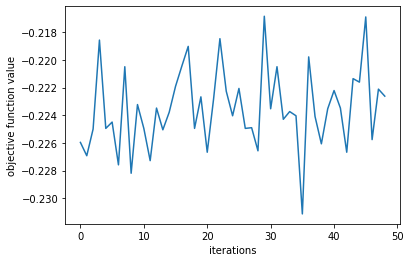

In [57]:
def GIVE_ENERGY(theta_ia_theta_jab_list):
    theta_ia = theta_ia_theta_jab_list[:len(theta_parameters_ia)]
    theta_ijab = theta_ia_theta_jab_list[len(theta_parameters_ia):]
    
    ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

    VQE_exp_UP = VQE_Experiment_UP(anti_commuting_sets, ansatz_cirq_circuit, n_shots, S_key_dict=None)#{7:1, 8:1, 9:0, 10:0})
    
    return VQE_exp_UP.Calc_Energy()

### optimizer
from quchem.Scipy_Optimizer import *
# THETA_params = [*theta_parameters_ia, *theta_parameters_ijab]
THETA_params=[0,1,2]
GG = Optimizer(GIVE_ENERGY, THETA_params, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()

# REDUCED H2 ANSATZ

In [59]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz(theta):
    HF_circ = [cirq.X.on(cirq.LineQubit(0)), cirq.X.on(cirq.LineQubit(1))]
    
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1 X2 X3', -1j), theta)
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit
    
H2_ansatz(np.pi)    

0: ───X───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───
                     │                              │
1: ───X───H──────────X───@──────────────────────@───X───H───────────
                         │                      │
2: ───H──────────────────X───@──────────────@───X───H───────────────
                             │              │
3: ───H──────────────────────X───Rz(2.0π)───X───H───────────────────

In [75]:
n_shots=1000

def GIVE_ENERGY(THETA):
    H2_ansatz_cirq_circuit = H2_ansatz(THETA)
    VQE_exp_UP = VQE_Experiment_UP(anti_commuting_sets, H2_ansatz_cirq_circuit, n_shots, S_key_dict=None)
    
    return VQE_exp_UP.Calc_Energy()


-1.1226789867996876


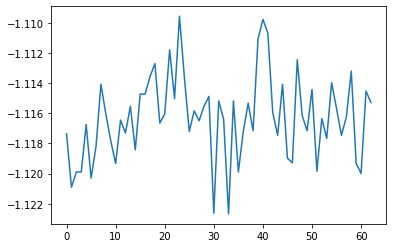

In [77]:
### full angle scan

import matplotlib.pyplot as plt
%matplotlib inline

theta_list = np.arange(0,2*np.pi, 0.1)

E_list = [GIVE_ENERGY(theta) for theta in theta_list]

plt.plot(E_list)
print(min(E_list))